In [1]:
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline

from scipy import stats
import random

In [3]:
conn = sqlite3.connect('spotify_song_data.db')
c = conn.cursor()
    
regression_query = """SELECT substr(rel_date,0,5) AS rel_year,
CASE WHEN (substr(rel_date,0,5) >= '1930' AND substr(rel_date,0,5) < '1940') THEN '1930'
    WHEN (substr(rel_date,0,5) >= '1940' AND substr(rel_date,0,5) < '1950') THEN '1940'
    WHEN (substr(rel_date,0,5) >= '1950' AND substr(rel_date,0,5) < '1960') THEN '1950'
    WHEN (substr(rel_date,0,5) >= '1960' AND substr(rel_date,0,5) < '1970') THEN '1960'
    WHEN (substr(rel_date,0,5) >= '1970' AND substr(rel_date,0,5) < '1980') THEN '1970'
    WHEN (substr(rel_date,0,5) >= '1980' AND substr(rel_date,0,5) < '1990') THEN '1980'
    WHEN (substr(rel_date,0,5) >= '1990' AND substr(rel_date,0,5) < '2000') THEN '1990'
    WHEN (substr(rel_date,0,5) >= '2000' AND substr(rel_date,0,5) < '2010') THEN '2000'
    WHEN (substr(rel_date,0,5) >= '2010' AND substr(rel_date,0,5) < '2020') THEN '2010'
    ELSE 'pre 1930' END
AS decade,

tempo, danceability, valence, 
energy, acousticness, instrumentalness

FROM song_analysis
WHERE tempo is not null AND tempo != 0.0
AND danceability is not null
AND valence is not null
AND energy is not null
AND acousticness is not null
AND instrumentalness is not null
AND substr(rel_date,0,5) >= '1899'
AND liveness is not null 
ORDER BY rel_date DESC"""

dfSpotify = pd.read_sql_query(regression_query, conn)
dfSpotify = dfSpotify.dropna()

conn.close()

dfSpotify.head()

,rel_year,decade,tempo,danceability,valence,energy,acousticness,instrumentalness
0,2018,2010,125.030,0.864,0.316,0.735,0.007340,0.716
1,2018,2010,80.363,0.507,0.231,0.196,0.803000,0.000
2,2018,2010,104.996,0.633,0.517,0.822,0.053900,0.000
3,2018,2010,201.862,0.334,0.204,0.417,0.749000,0.000
4,2018,2010,125.996,0.770,0.961,0.623,0.000308,0.706


In [4]:
def regression_by_decade():
    #finds song traits that are correlated in a specific decade.
    #If correlated, plots the change in correlation of the two traits over ALL decades.
    
    decades = ['1930', '1940', '1950','1960','1970','1980','1990','2000','2010'];
    high_corrs = []
    
    for decade in decades:
        df_Decade = dfSpotify.loc[dfSpotify.decade == decade]
        
        # Correlation coefficients for all attributes
        trait_correlations = df_Decade.corr()
        
        #grab any trait correlations > 0.4
        for row in trait_correlations.iterrows():
            index, data = row
            
            row_i = data.tolist()
            for corr in row_i:
                if (abs(corr) > 0.3 and corr != 1.0):
                    trait1, trait2 = index, trait_correlations.columns[row_i.index(corr)]
                    if ([trait1, trait2] not in high_corrs) and ([trait2, trait1] not in high_corrs):
                        high_corrs.append([trait1, trait2 ])
    
    #calculate all correlation coefficients for chosen
    for traits in high_corrs:
        correlations = []
        
        trait1, trait2 = traits[0], traits[1]
        df_t1 = dfSpotify[trait1]
        df_t2 = dfSpotify[trait2]
    
        for decade in decades:
            t1_data = (df_t1.loc[dfSpotify.decade == decade]).tolist()
            t2_data = (df_t2.loc[dfSpotify.decade == decade]).tolist()

            slope, intercept, r_value, p_value, std_err = stats.linregress(t1_data, t2_data)
            correlations.append([r_value, decade])
        
        plot_correlation(trait1, trait2, correlations)
    return

def plot_correlation(trait1, trait2, correlations):
    #Plots the change in correlations over time
    fig, ax = plt.subplots(1,1, figsize=(8,5))
    
    years = [corr[1] for corr in correlations]
    x_vals = np.arange(len(years))
    r_vals = [corr[0] for corr in correlations]
    
    width = 0.4
    plt.bar(x_vals, r_vals, width, color='blue')
    
    plt.xticks(x_vals, years)
    plt.title(trait1 + " vs. " + trait2 + ", correlation over time")
    ax.set_xlabel("Year")
    ax.set_ylabel("Correlation")
    
    plt.show()
    '''for i, corr in enumerate(correlations):
        #x_vals = np.arange(yrs[i]*10, yrs[i+])
        x_vals = np.arange(int(decade), int(decade)+10)
        y_vals = corr[2] + corr[1] * x_vals # r + slope*year
        r_val = r_val + corr[1]*10
                  #for i in range(0, len(x_vals))]'''



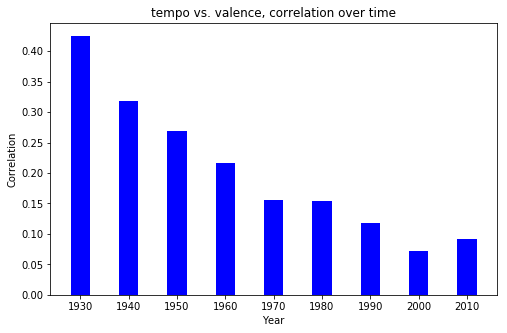

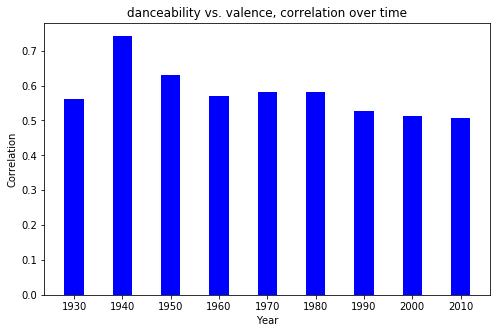

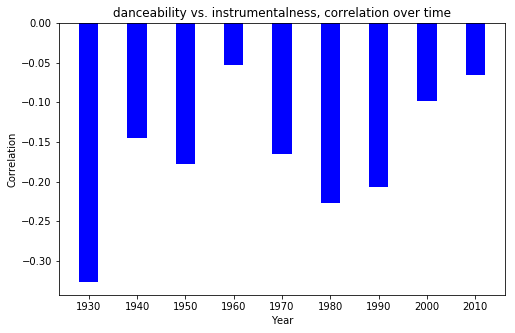

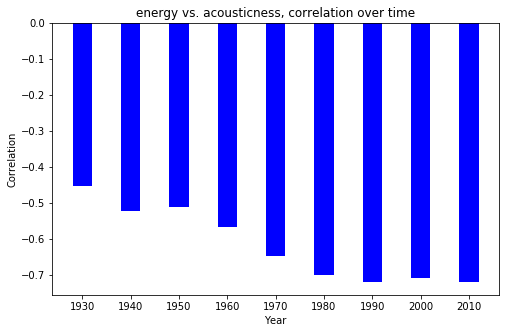

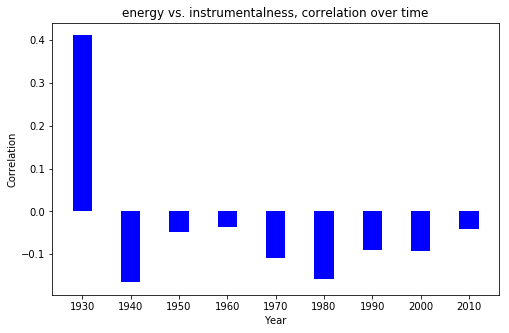

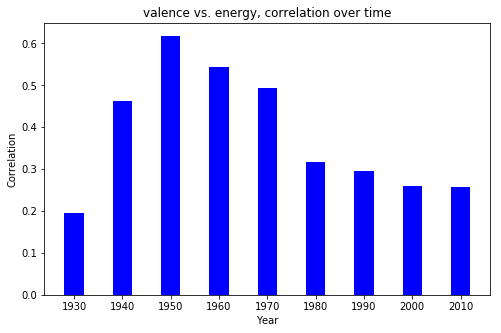

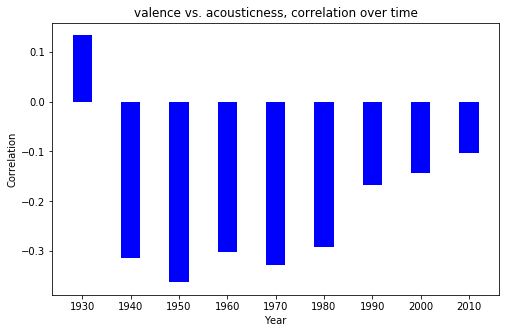

In [5]:
regression_by_decade()

In [2]:
def k_means_clustering(trait_name):
    #Takes all songs for a numerical trait in a 4 year span
    #Initializes low/medium/high clusters w/ centroids at 0.25, 0.5, 0.75
    #Evaluates to find k-means centroids
    #Plots the low/med/high centroid points, and overall average over time

    year_clusters = [] #[start year, low, med, high]
    
    for year in range(1920, 2010, 5):
        k_means_query = """SELECT substr(rel_date,0,5) AS rel_date, """ +trait_name+ """ FROM song_analysis
        WHERE """ +trait_name+ """ is not null AND 
        rel_date >= """ +str(year)+ """ AND rel_date < """ + str(year+4) + """;""";
        
        conn = sqlite3.connect('spotify_song_data.db')
        c = conn.cursor()
        df_years = pd.read_sql_query(k_means_query, conn)
        df_years = df_years.dropna()
        conn.close()
        
        data = df_years[trait_name].tolist()
        
        #compute 4 rounds of 3-means clustering
        random.seed(0)
        c1 = data[random.randint(0, len(data))]
        c2 = data[random.randint(0, len(data))]
        c3 = data[random.randint(0, len(data))]
        
        for i in range(1, 7):
            c1_new = []
            c2_new = []
            c3_new = []
            
            for t_val in data:
                #Place value in the correct centroid
                c1_dist, c2_dist, c3_dist = abs(t_val-c1), abs(t_val-c2), abs(t_val-c3)
                if (min(c1_dist, c2_dist, c3_dist) == c1_dist):
                    c1_new.append(t_val)
                elif (min(c2_dist, c3_dist) == c2_dist):
                    c2_new.append(t_val)
                else:
                    c3_new.append(t_val)
            
            c1c2c3 = [np.mean(c1_new), np.mean(c2_new), np.mean(c3_new)]
            
            c1 = min(c1c2c3)
            c1c2c3.remove(min(c1c2c3))
            
            c3 = max(c1c2c3)
            c1c2c3.remove(max(c1c2c3))
            
            c2 = c1c2c3[0]
        #end k-means
        
        year_clusters.append([year, c1, c2, c3])
        
        #print ([year, c1, c2, c3])
        
    #Plot data
    plot_k_means(trait_name, year_clusters)

In [3]:
def plot_k_means(trait_name, year_clusters):    
    #plot the change in low, midpoint, and high point clusters over time
    years = [val[0] for val in year_clusters]
    x_vals = np.arange(len(years))
    
    low_vals = [val[1] for val in year_clusters]
    mid_vals = [val[2] for val in year_clusters]
    hi_vals = [val[3] for val in year_clusters]
    
    fig = plt.figure(figsize=(11,8))
    ax = fig.add_subplot(1, 1, 1)
    
    ax.plot(x_vals, low_vals, '-o', alpha=0.8, color="red", label="low")
    ax.plot(x_vals, mid_vals, '-o', alpha=0.8, color="blue", label="medium")
    ax.plot(x_vals, hi_vals, '-o', alpha=0.8, color="green", label="high")

    plt.xticks(x_vals, years)
    plt.title("3-means clustering - centroids of song " + trait_name)
    plt.legend(loc=2)
    ax.set_xlabel("Year")
    ax.set_ylabel(trait_name)
    plt.show()

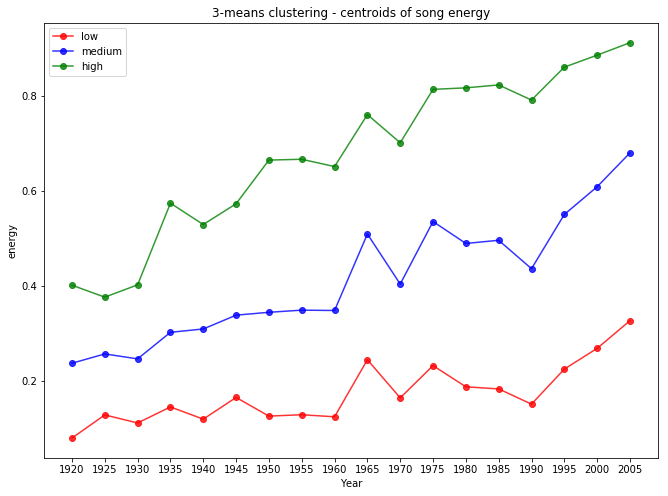

In [8]:
k_means_clustering('energy')

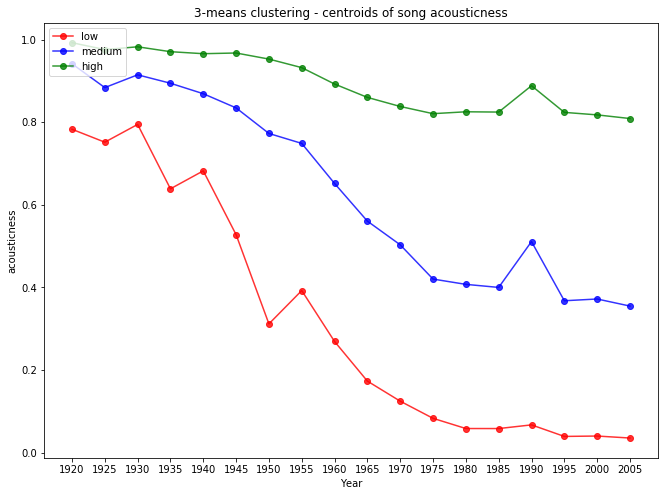

In [9]:
k_means_clustering('acousticness')

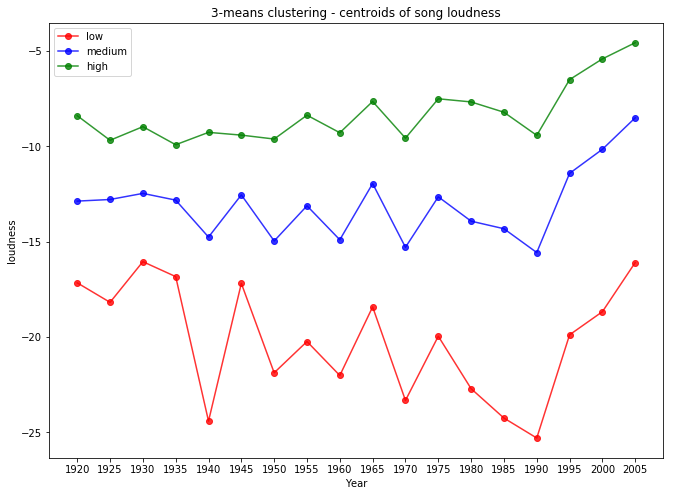

In [6]:
k_means_clustering('loudness')

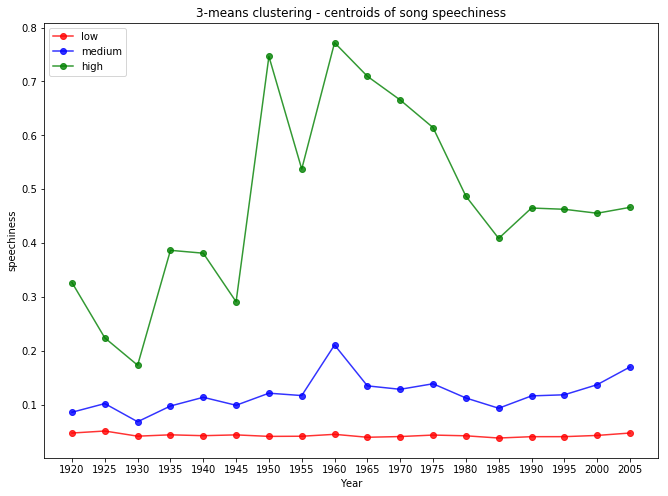

In [8]:
k_means_clustering('speechiness')

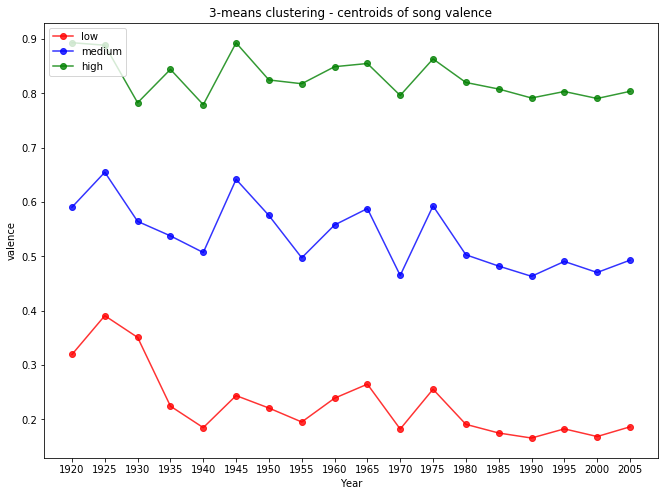

In [10]:
k_means_clustering('valence')

In [9]:
'''select
id,
name,
artist,
cast(substr(rel_date,0,5) as int) as rel_year,
case when (substr(rel_date,0,5) < '1910') then '1900s'
    when (substr(rel_date,0,5) >= '1910' and substr(rel_date,0,5) < '1920') then '1910s'
    when (substr(rel_date,0,5) >= '1920' and substr(rel_date,0,5) < '1930') then '1920s'
    when (substr(rel_date,0,5) >= '1930' and substr(rel_date,0,5) < '1940') then '1930s'
    when (substr(rel_date,0,5) >= '1940' and substr(rel_date,0,5) < '1950') then '1940s'
    when (substr(rel_date,0,5) >= '1950' and substr(rel_date,0,5) < '1960') then '1950s'
    when (substr(rel_date,0,5) >= '1960' and substr(rel_date,0,5) < '1970') then '1960s'
    when (substr(rel_date,0,5) >= '1970' and substr(rel_date,0,5) < '1980') then '1970s'
    when (substr(rel_date,0,5) >= '1980' and substr(rel_date,0,5) < '1990') then '1980s'
    when (substr(rel_date,0,5) >= '1990' and substr(rel_date,0,5) < '2000') then '1990s'
    when (substr(rel_date,0,5) >= '2000' and substr(rel_date,0,5) < '2010') then '2000s'
    when (substr(rel_date,0,5) >= '2010' and substr(rel_date,0,5) < '2020') then '2010s'
    end dateClass,
explicit,
case when (explicit = 0) then 'clean'
    when (explicit = 1) then 'explicit'
    end explicitClass,
time_signature,
key,
tempo,
case when (tempo <= 50) then 'very slow'
    when (tempo > 50 and tempo <= 100) then 'slow'
    when (tempo > 100 and tempo <= 150) then 'moderate'
    when (tempo > 150 and tempo <= 200) then 'fast'
    when (tempo > 200 and tempo <= 250) then 'very fast'
    end tempoClass,
mode,
case when (mode = 0) then 'minor'
    when (mode = 1) then 'major'
    end modeClass,
duration_ms,
case when (duration_ms <= 120000) then 'very short'
    when (duration_ms > 120000 and duration_ms <= 180000) then 'short'
    when (duration_ms > 180000 and duration_ms <= 240000) then 'medium'
    when (duration_ms > 240000 and duration_ms <= 300000) then 'long'
    when (duration_ms > 300000) then 'very long'
    end durationClass,
danceability,
case when (danceability <= 0.25) then 'low danceability'
    when (danceability > 0.25 and danceability <= 0.50) then 'low/moderate danceability'
    when (danceability > 0.50 and danceability <= 0.75) then 'moderate/high danceability'
    when (danceability > 0.75) then 'high danceability'
    end danceabilityClass,
valence,
case when (valence <= 0.25) then 'low valence'
    when (valence > 0.25 and valence <= 0.50) then 'low/moderate valence'
    when (valence > 0.50 and valence <= 0.75) then 'moderate/high valence'
    when (valence > 0.75) then 'high valence'
    end valenceClass,
energy,
case when (energy <= 0.25) then 'low energy'
    when (energy > 0.25 and energy <= 0.50) then 'low/moderate energy'
    when (energy > 0.50 and energy <= 0.75) then 'moderate/high energy'
    when (energy > 0.75) then 'high energy'
    end energyClass,
loudness,
case when (loudness < -45 ) then 'very quiet'
    when (loudness > -45 and loudness <= -30) then 'quiet'
    when (loudness > -30 and loudness <= -15) then 'moderate'
    when (loudness > -15 and loudness <= 0) then 'loud'
    when (loudness > 0 and loudness <= 15) then 'very loud'
    end loudnessClass,
speechiness,
case when (speechiness <= 0.33) then 'just music'
    when (speechiness > 0.33 and speechiness <= 0.66) then 'both music and speech'
    when (speechiness > 0.66) then 'just speech'
    end speechinessClass,
acousticness,
case when (acousticness <= 0.25) then 'low acousticness'
    when (acousticness > 0.25 and acousticness <= 0.50) then 'low/moderate acousticness'
    when (acousticness > 0.50 and acousticness <= 0.75) then 'moderate/high acousticness'
    when (acousticness > 0.75) then 'high acousticness'
    end acousticnessClass,
instrumentalness,
case when (instrumentalness <= 0.25) then 'less instrumental'
    when (instrumentalness > 0.25 and instrumentalness <= 0.75) then 'moderate instrumentalness'
    when (instrumentalness > 0.75) then 'more instrumental'
    end instrumentalnessClass,
liveness,
case when (liveness <= 0.33) then 'studio recording'
    when (liveness > 0.33 and liveness <= 0.66) then 'moderate liveness'
    when (liveness > 0.66) then 'live recording'
    end livenessClass
from song_analysis
where
key is not null
and tempo is not null
and mode is not null
and duration_ms is not null
and danceability is not null
and valence is not null
and energy is not null
and loudness is not null
and speechiness is not null
and instrumentalness is not null
and substr(rel_date,0,5) >= '1899'
and tempo != 0.0
and time_signature != 0
and liveness is not null
and duration_ms >= 60000;'''

"select\nid,\nname,\nartist,\ncast(substr(rel_date,0,5) as int) as rel_year,\ncase when (substr(rel_date,0,5) < '1910') then '1900s'\n    when (substr(rel_date,0,5) >= '1910' and substr(rel_date,0,5) < '1920') then '1910s'\n    when (substr(rel_date,0,5) >= '1920' and substr(rel_date,0,5) < '1930') then '1920s'\n    when (substr(rel_date,0,5) >= '1930' and substr(rel_date,0,5) < '1940') then '1930s'\n    when (substr(rel_date,0,5) >= '1940' and substr(rel_date,0,5) < '1950') then '1940s'\n    when (substr(rel_date,0,5) >= '1950' and substr(rel_date,0,5) < '1960') then '1950s'\n    when (substr(rel_date,0,5) >= '1960' and substr(rel_date,0,5) < '1970') then '1960s'\n    when (substr(rel_date,0,5) >= '1970' and substr(rel_date,0,5) < '1980') then '1970s'\n    when (substr(rel_date,0,5) >= '1980' and substr(rel_date,0,5) < '1990') then '1980s'\n    when (substr(rel_date,0,5) >= '1990' and substr(rel_date,0,5) < '2000') then '1990s'\n    when (substr(rel_date,0,5) >= '2000' and substr(rel_